<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/practicaldl/Practical-Deep-Learning-Book/blob/master/code/chapter-3/2-analyzing-the-results.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/practicaldl/Practical-Deep-Learning-Book/blob/master/code/chapter-3/2-analyzing-the-results.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This code is part of [Chapter 3: Cats versus Dogs: Transfer Learning in 30 Lines with Keras](https://learning.oreilly.com/library/view/practical-deep-learning/9781492034858/ch03.html).

Note: In order to run this notebook on Google Colab you need to [follow these instructions](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb#scrollTo=WzIRIt9d2huC) so that the local data such as the images are available in your Google Drive.

# Analyzing the Results

With our trained model, we can analyze how it's performing over the validation dataset. Beyond the simpler accuracy metrics, looking at the actual images of mispredictions should give an intuition on whether the example was truly hard or if our model is not sophisticated enough. 

There are 3 questions we want to answer for each category (cat, dog):
- Which images are we most confident about being a cat/dog?
- Which images are we least confident about being a cat/dog?
- Which images have incorrect predictions in spite of being highly confident?


## Loading the model and data

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Let's set the pipeline configuration correctly: 


In [2]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
# IMG_WIDTH, IMG_HEIGHT = 56, 56
VALIDATION_DATA_DIR = 'data/val/'
VALIDATION_BATCH_SIZE = 64
# VALIDATION_BATCH_SIZE = 32

As before, let's read the data and do the augmentation.

In [3]:
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=VALIDATION_BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 500 images belonging to 2 classes.


Now, let's load the model.

In [4]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform

with CustomObjectScope(
    {'GlorotUniform': glorot_uniform()}):
    model = load_model('data/model.h5')

[2021-06-11 21:53:53.013 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:362 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-06-11 21:53:53.038 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:362 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


## Prepping for the analysis

Let's prepare some helper variables that will help us do the analysis.

In [5]:
# Let's view the names of the files.
filenames = validation_generator.filenames
print(len(filenames))
print(filenames[:10])

500
['cat/cat.10004.jpg', 'cat/cat.10026.jpg', 'cat/cat.1003.jpg', 'cat/cat.10049.jpg', 'cat/cat.10101.jpg', 'cat/cat.10201.jpg', 'cat/cat.10254.jpg', 'cat/cat.1041.jpg', 'cat/cat.10432.jpg', 'cat/cat.10445.jpg']


Let's check what the ground truth looks like.

In [6]:
ground_truth = validation_generator.classes
print(ground_truth[:10])
print(len(ground_truth))

[0 0 0 0 0 0 0 0 0 0]
500


Let's confirm the which category names corresponds to which category id.

In [7]:
label_to_index = validation_generator.class_indices
print(label_to_index)

{'cat': 0, 'dog': 1}


Now, let's develop a reverse mapping from the class index to class label. Observe that classes are picked in alphabetical order.

In [8]:
index_to_label = dict((v, k) for k, v in label_to_index.items())
print(index_to_label)

{0: 'cat', 1: 'dog'}


Then we get the predictions. This will be a list of probability values that express how confident the model is about the presence of each category in each image. This step might take several minutes.

In [9]:
predictions = model.predict_generator(validation_generator,
                                      steps=None)

Instructions for updating:
Please use Model.predict, which supports generators.


Instructions for updating:
Please use Model.predict, which supports generators.


Take a look at what these predictions look like.

In [10]:
print(predictions[:10])

[[9.9979955e-01 2.0047322e-04]
 [9.2237008e-01 7.7629946e-02]
 [9.9936777e-01 6.3219771e-04]
 [9.9997163e-01 2.8394332e-05]
 [9.9821907e-01 1.7808870e-03]
 [9.9997628e-01 2.3699793e-05]
 [9.9978012e-01 2.1988250e-04]
 [9.9959570e-01 4.0429411e-04]
 [9.3366295e-01 6.6337004e-02]
 [9.9999654e-01 3.4261293e-06]]


For each image, the model gives us the probability values, but we need to check which probability is higher helping us understand which prediction does the model stand with. In other words we need to check which probability value is higher for which we can use the `numpy` functionality of `argmax`.

In [11]:
prediction_index = []
for prediction in predictions:
    prediction_index.append(np.argmax(prediction))

Now that we have the predictions, we need to compare them against the ground truth to see how good the model really is. In order to do this, let's develop a helper function to calculate accuracy.

In [12]:
def accuracy(predictions, ground_truth):
    total = 0
    for i, j in zip(predictions, ground_truth):
        if i == j:
            total += 1
    return total * 1.0 / len(predictions)

In [13]:
print(accuracy(prediction_index, ground_truth))

0.988


To make our analysis easier, we make a dictionary storing the image index to the prediction and ground truth (the expected prediction) for each image.


In [14]:
prediction_table = {}
for index, val in enumerate(predictions):
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [
        value_of_highest_probability, index_of_highest_probability,
        ground_truth[index]
    ]
assert len(predictions) == len(ground_truth) == len(prediction_table)

For the next two code blocks, we provide boilerplate code which we will be reusing regularly throughout the book.

We’ll make a helper function called `get_images_with_sorted_probabilities` to find the images with the highest/lowest probability value for a given category. These are the input arguments:
- `prediction_table`: dictionary from the image index to the prediction and ground truth for that image
- `get_highest_probability`: boolean flag to indicate if the results need to be highest (True) or lowest (False) probabilities
- `label`: intgeger id of category
- `number_of_items`: num of results to return
- `only_false_predictions`: boolean flag to indicate if results should only contain incorrect predictions


In [15]:
def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

Let's make some helper functions to plot the nearest images given a query image.

In [16]:
def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
        
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(VALIDATION_DATA_DIR + filenames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

## Analysis

Great! We have all the helper functions ready. Now all we have to do is call them.

Note: The images preloaded in the notebook are based on the model, we (i.e, the authors) trained. Although the model trained is based on the same architecture as in previous notebooks, there may be slight statistic differences in the models. As a result the images you see below, versus the images that may load when you run the notebook may be different.

### Most confident predictions of `dog`

Which images are we most confident contain dogs? Let's find images with the highest prediction probability (i.e. closest to 1.0) with the predicted class dog (i.e. 1).

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


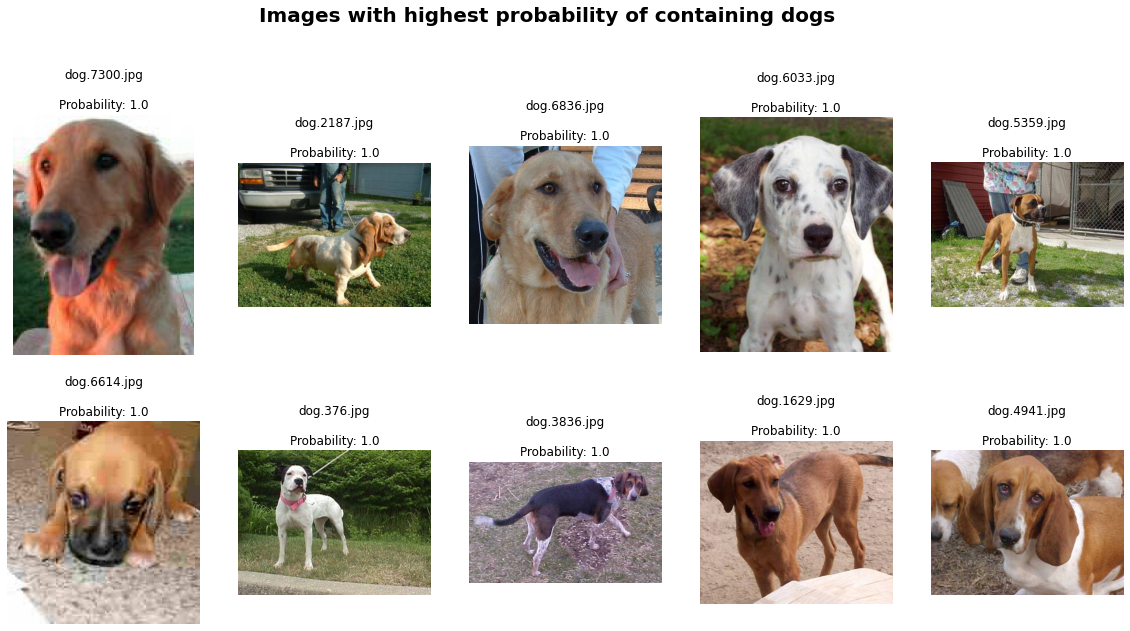

In [17]:
most_confident_dog_images = get_images_with_sorted_probabilities(prediction_table, True, 1, 10,
                                               False)
message = 'Images with highest probability of containing dogs'
display(most_confident_dog_images, message)

These images are indeed very dog-like. One of the reasons why the probability is so high can be attributed to containing multiple dogs, as well as clear, unambiguous views. 

### Least confident predictions of `dog`

What about the images that are least confident of containing dogs?

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


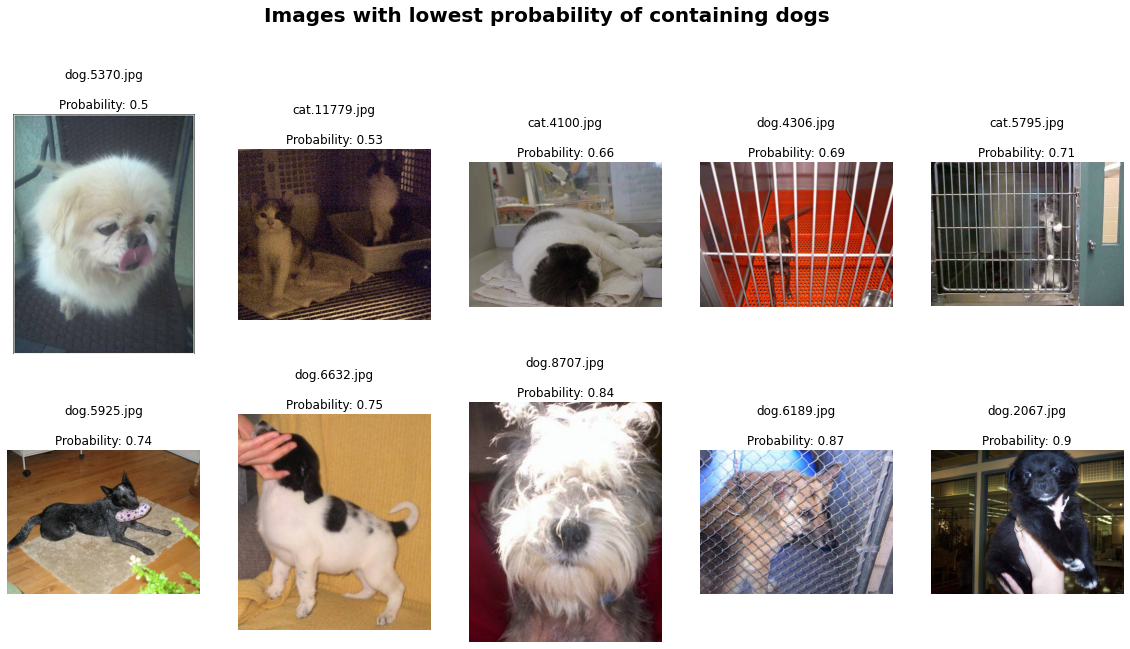

In [18]:
least_confident_dog_images = get_images_with_sorted_probabilities(prediction_table, False, 1, 10,
                                               False)
message = 'Images with lowest probability of containing dogs'
display(least_confident_dog_images, message)

To repeat, these are the images our classifier is most unsure of containing a dog. Most of these predictions are right at the tipping point (i.e. 0.5 probability) to be the majority prediction. Keep in mind the probability of being a cat is just slightly smaller, around 0.49. Compared to the previous set of images, these images are often smaller and less clear images. And often contain mispredictions - only 2 of the 10 images were the correctly predicted. One possible way to do better here is training with a larger set of images.

If you are concerned about these misclassifications, don't worry! A simple trick to improve the classification accuracy is to have a higher threshold for accepting a classifier’s results, say 0.75. If the classifier is unsure of an image category, its results are withheld. In chapter 4, we will look at how to find an optimal threshold.

Talking of mispredictions, they are obviously expected when the classifier has low confidence (i.e. near 0.5 probability for a 2 class problem). But what we don’t want is to mispredict when our classifier is really sure of its predictions. Let’s check which images the classifier is confident contain dogs in spite of them being cats.

### Incorrect predictions of `dog`

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


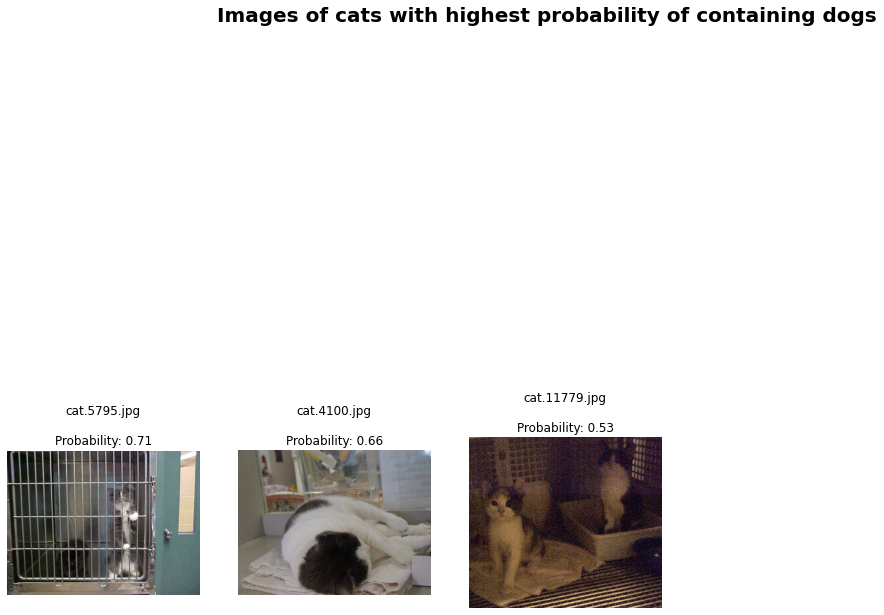

In [19]:
incorrect_dog_images = get_images_with_sorted_probabilities(prediction_table, True, 1, 10,
                                               True)
message = 'Images of cats with highest probability of containing dogs'
display(incorrect_dog_images, message)

Hmm… turns out half of these images contain both cats and dogs, and our classifier is correctly predicting the dog category as they are bigger in size in these images. Thus it's not the classifier but the data which is incorrect here. This often happens in large datasets. The remaining half often contain unclear and relatively smaller objects (but ideally we want to expect lower confidence for these hard to identify images).


Repeating the same set of question for the cat class, which images are more cat-like?


### Most confident predictions of `cat`

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


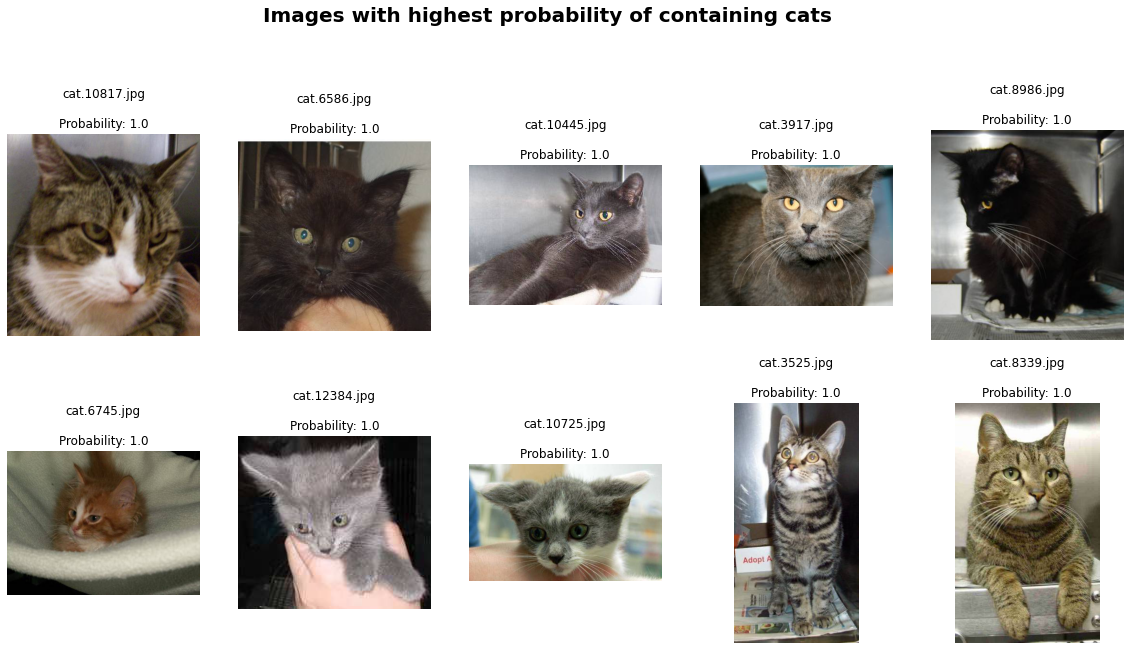

In [20]:
most_confident_cat_images = get_images_with_sorted_probabilities(prediction_table, True, 0, 10,
                                               False)
message = 'Images with highest probability of containing cats'
display(most_confident_cat_images, message)

Interestingly, many of these have multiple cats. This affirms our previous hypothesis that multiple clear, unambiguous views of cats can give higher probabilities. 

On the other hand, which images are we most unsure about containing cats?

### Least confident predictions of `cat`

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


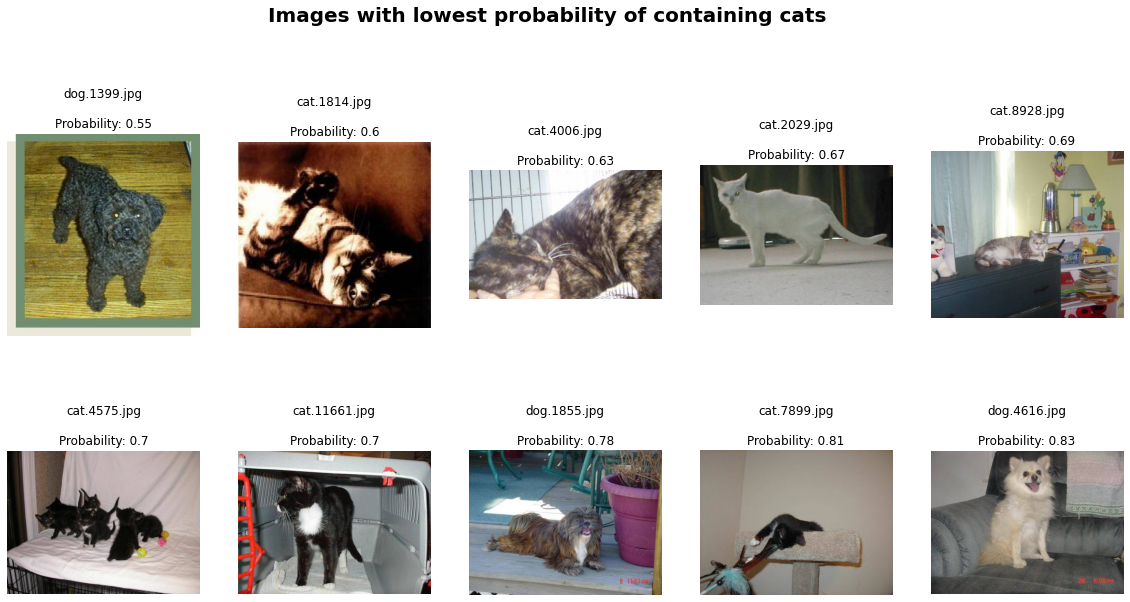

In [21]:
least_confident_cat_images = get_images_with_sorted_probabilities(prediction_table, False, 0, 10,
                                               False)
message = 'Images with lowest probability of containing cats'
display(least_confident_cat_images, message)

Like previously seen, the key object size is small, and some of the images are quite unclear meaning there is too much contrast in some cases or the object is too bright, something not in line with most of the training images. For example, the camera flash in the eighth (dog.6680) and tenth (dog.1625) images makes it hard to recognize. The sixth image contains a dog in front of a sofa of the same color. Two images contain cages. 

Lastly, which images is our classifier mistakenly sure of containing cats?

### Incorrect predictions of `cat`

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


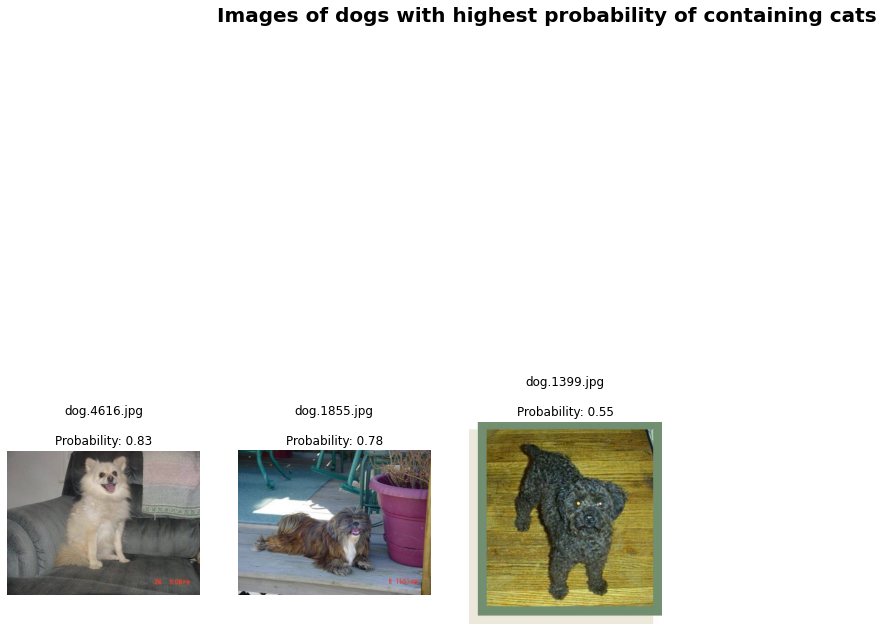

In [22]:
incorrect_cat_images = get_images_with_sorted_probabilities(prediction_table, True, 0, 10,
                                               True)
message = 'Images of dogs with highest probability of containing cats'
display(incorrect_cat_images, message)

These mispredictions are what we want to reduce. Some of them are clearly wrong, while others are understandably confusing images. The sixth image (dog.4334) seems to be incorrectly labeled as a dog. Seventh and tenth images are difficult to distinguish against the background. The first and tenth lack enough texture within them to give the classifier enough identification power. And some of the dogs are too small, like the second and fourth.